## Imports & Setup

In [154]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from helpers import *
from torch.autograd import Variable

import math



In [155]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [156]:
torch.manual_seed(555)

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [158]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), 
                          Resize((size, size)), ToTensor(), Normalize(mean=[0.4815], std=[0.2135])])

In [159]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)

In [160]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [161]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[4594, 3587, 2840, 3156, 1471, 2392, 226, 1836, 4559]


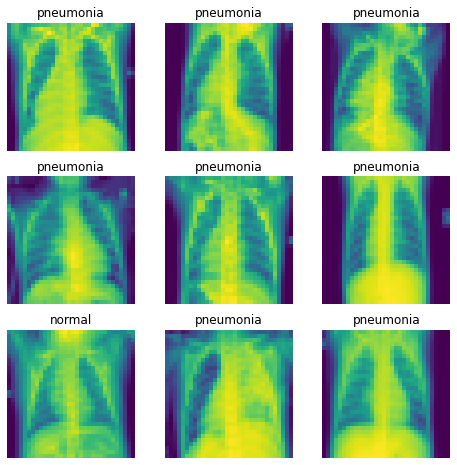

In [162]:
visualize_data(train_data)

[119, 194, 370, 321, 45, 577, 282, 429, 233]


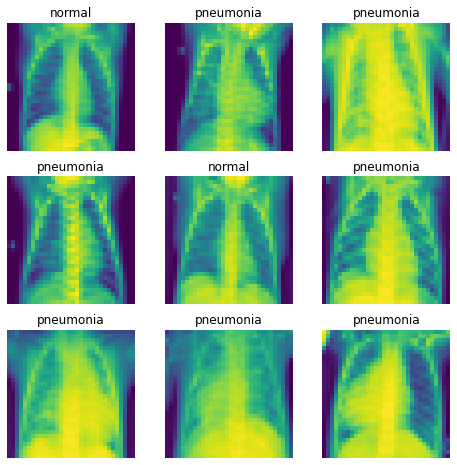

In [163]:
visualize_data(test_data)

## Model Definition

In [164]:
class Encoder(torch.nn.Module):
    
    def __init__(self,inputs,outputs,kernel):
        super(Encoder, self).__init__()
        
        self.conv=nn.Conv2d(inputs, outputs,kernel_size=kernel)
        self.batchnorm=nn.BatchNorm2d(outputs)
        self.relu=nn.LeakyReLU()
        
        
        
    def forward(self,x):
        x=self.conv(x)
        x=self.batchnorm(x)
        x=self.relu(x)
        
        
        
        return x
    

In [165]:
class Decoder(torch.nn.Module):
    
    def __init__(self,inputs,outputs,kernel,output_pad=1):
        super(Decoder,self).__init__()
        self.convt=nn.ConvTranspose2d(inputs,outputs,kernel_size=kernel)
        self.batchnorm=nn.BatchNorm2d(outputs)
        self.relu=nn.ReLU()
        
    def forward(self,x):
        x=self.convt(x)
        x=self.batchnorm(x)
        x=self.relu(x)
        return x
        


In [166]:
class AutoEncoder(torch.nn.Module):
    def __init__(self,inputs,hidden):
        super(AutoEncoder,self).__init__()
        self.enc1=Encoder(inputs,hidden[0],3)
        self.enc2=Encoder(hidden[0],hidden[1],3)
        self.enc3=Encoder(hidden[1],hidden[2],7)
        
        self.dec1=Decoder(hidden[2],hidden[1],7)
        self.dec2=Decoder(hidden[1],hidden[0],3)
        self.dec3=Decoder(hidden[0],inputs,3)
                

        self.enc=nn.Sequential(self.enc1,self.enc2,self.enc3)
        self.dec=nn.Sequential(self.dec1,self.dec2,self.dec3)
        
        
    def forward(self,x):
        x=self.enc(x)
        x=self.dec(x)
#         print(x.shape)
#         x = x.view(-1, self.flattened)
#         x=self.class1(x)
        
        
        return x
    


In [167]:
class Encoder1(torch.nn.Module):
    
    def __init__(self,inputs,hidden,kernel=3):
        super(Encoder1, self).__init__()
        
        self.enc1=Encoder(inputs,hidden[0],3)
        self.enc2=Encoder(hidden[0],hidden[1],3)
        self.enc3=Encoder(hidden[1],hidden[2],7)
        self.enc=nn.Sequential(self.enc1,self.enc2,self.enc3)
        
    def forward(self,x):
        x=self.enc(x)
        
        return x
    

## Train the autoencoder

In [168]:
# number of hidden layers and their sizes
hidden = [16,32,64]
inputs = 1

# kernel size of convolution layers
kernel_size = 3



autoencmodel=AutoEncoder(inputs,hidden).to(device)
autoencmodel

AutoEncoder(
  (enc1): Encoder(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (enc2): Encoder(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (enc3): Encoder(
    (conv): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (dec1): Decoder(
    (convt): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (dec2): Decoder(
    (convt): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (batchn

In [169]:
def create_adam_optimizer(model,lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [171]:
outputs_list = []
loss_list = []
criterion=nn.MSELoss()
num_epochs=4

In [79]:
outputs_list = []
loss_list = []
criterion=nn.MSELoss()
num_epochs=10
optimizer=create_adam_optimizer(autoencmodel,lr=0.001)
for epoch in range(num_epochs):
    for data in train_loader:
        
        # Send data to device
        img, _ = data
        img = Variable(img).to(device)
        
        # Forward pass
        output = autoencmodel(img)
        loss = criterion(output, img)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, 5, loss.item()))
    outputs_list.append((epoch, img, output),)
    loss_list.append(loss.item())

epoch 1/5, loss 0.6911
epoch 2/5, loss 0.6868
epoch 3/5, loss 0.6838
epoch 4/5, loss 0.6852


In [196]:
#save encoder weights , can change fileneame 
torch.save({'model_state_dict': autoencmodel.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, './autoenc1')

In [172]:
#display decoded images
for k in range(0, num_epochs, 4):
    plt.figure(figsize = (9, 2))
    print(outputs_list[k][1].size())
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

IndexError: list index out of range

<Figure size 648x144 with 0 Axes>

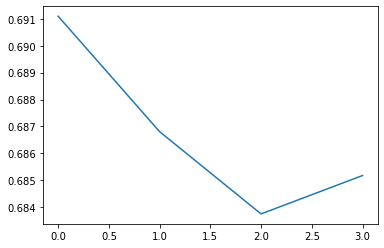

In [82]:
plt.figure()
plt.plot(loss_list)
plt.show()

## CNN model definition

In [174]:
class DeepLearnConv(torch.nn.Module):
    def __init__(self, inputs, outputs, weights, kernel_size):
        super(DeepLearnConv, self).__init__()
        
        self.conv = nn.Conv2d(inputs, outputs, kernel_size = kernel_size)
        with torch.no_grad():
            self.conv.weight = nn.Parameter(weights)
        self.batch_norm = nn.BatchNorm2d(outputs)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x

In [175]:
class DeepLearnLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepLearnLinear, self).__init__()
        
        self.linear = nn.Linear(inputs, outputs)
        nn.init.xavier_uniform_(self.linear.weight)
        self.batch_norm = nn.BatchNorm1d(outputs)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x

In [185]:
class DeepLearn(torch.nn.Module):
    def __init__(self, kernels, hidden, kernel_size, window, hidden_linear, labels):
        super(DeepLearn, self).__init__()
        
        self.kernels = kernels
        self.conv = [DeepLearnConv(hidden[i], hidden[i+1], 
                                    self.kernels[i].view(1, 1, 3, 3).repeat(hidden[i+1], hidden[i], 1, 1), 
                                    kernel_size) for i in range(len(hidden)-1)]
        self.conv_combined = nn.Sequential(*self.conv)
        
        self.maxpool = nn.MaxPool2d(window)
        self.flattened = hidden_linear[0]
        self.linear= [DeepLearnLinear(hidden_linear[i], hidden_linear[i+1]) for i in range(len(hidden_linear)-1)]
        self.linear_combined = nn.Sequential(*self.linear)
        
        self.output = nn.Linear(hidden_linear[-1], labels)
    
    def forward(self, x):
        x = self.conv_combined(x)
        x = self.maxpool(x)
        x = x.view(-1, self.flattened)
        x = self.linear_combined(x)
        x = self.output(x)
        return x

## Training Model & Hyperparameter Tuning

In [177]:
hidden = [16,32,64]

#create model of encoder
encodermod=Encoder1(inputs,hidden,outputs).to(device)

enc_dict={}
load_dict=torch.load("./autoenc1")["model_state_dict"]

# create state_dict() of only the encoder weights from the autoencoder model
for param_tensor in load_dict:
    if "enc" in param_tensor or "conv." in param_tensor:
        enc_dict[param_tensor]=load_dict[param_tensor]
        
encodermod.load_state_dict(enc_dict)
encodermod
# freeze the gradients for the encoder weights
for param in encodermod.parameters():
    param.requiresGrad = False

In [178]:
def create_adam_optimizer(model,lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [179]:
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [64, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
flattened=4096

# final linear layers and their sizes
hidden_linear = [flattened, 2048, 512, 64]
labels = 2

In [180]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [181]:
model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
optimiser = create_adam_optimizer(model,lr=0.01)
print(model)

DeepLearn(
  (conv_combined): Sequential(
    (0): DeepLearnConv(
      (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepLearnConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepLearnConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepLearnLinear(
      (linear): Linear(in_features=4096, out_features=2048, bias=True)
 

In [182]:
def test(device, model, data_loader, criterion,encoder,verbose=False):
    # Use cross-entropy loss function
    model.eval()
    # Initialize epoch loss and accuracy
    epoch_loss = 0.0
    correct = 0
    total = 0
    # Iterate over test data
    for inputs, labels in data_loader:
        # Get from dataloader and send to device
        inputs = inputs.to(device)
        #get encoded inputs
        inputs= encoder(inputs)
        
        labels = labels.to(device)
        # Compute model output and loss
        # (No grad computation here, as it is the test data)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        # Accumulate loss and correct predictions for epoch
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
    epoch_loss /= len(data_loader)
    epoch_acc = correct/total
    if verbose:
        print(f'Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc


In [183]:



def train(device, model, train_loader, valid_loader, optimizer,encoder, epochs = 1):
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    outputs_list=[]
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs=inputs.to(device)
            #get encoded inputs
            inputs = encoder(inputs)
            
            labels = labels.to(device)
            # Compute model output and loss
            
            outputs = model(inputs)
        
            
          
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            # Zero out gradients
            optimizer.zero_grad()
            
            
            
            
            
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            if (batch_number%5==0):
                print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimiser.state_dict()}, './encmodel')
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        outputs_list.append((epoch, inputs, outputs),)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        #Validation set
        epoch_loss, epoch_acc = test(device, model, valid_loader, criterion,encoder)
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Val loss: {epoch_loss:.4f}, Val accuracy: {epoch_acc:.4f}')      
    return train_losses, train_accuracies,val_losses,val_accuracies

In [184]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start
tl, ta, vl, va = train(device, model, train_loader, val_loader, encoder=encodermod,epochs = 1, optimizer = optimiser)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

torch.Size([128, 64, 8, 8])
Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.5390625
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
Epoch 1/1, Batch number: 5, Cumulated accuracy: 0.69140625
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
Epoch 1/1, Batch number: 10, Cumulated accuracy: 0.7379261363636364
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
Epoch 1/1, Batch number: 15, Cumulated accuracy: 0.759765625
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
Epoch 1/1, Batch number: 20, Cumulated accuracy: 0.7715773809523809
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([12

In [149]:
#just saves the latest weights
torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimiser.state_dict()}, './encmodel')

## Testing Model & Performance Curves

In [152]:
# epoch 26
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, encodermod,verbose=True)

torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([73, 64, 8, 8])
Test loss: 0.3890, Test accuracy: 0.9009


In [153]:
#epoch 26
torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimiser.state_dict()}, './encmodel9009')

In [150]:
# epoch 25
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, encodermod,verbose=True)

torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([73, 64, 8, 8])
Test loss: 0.3246, Test accuracy: 0.8991


In [146]:
# epoch 24
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, encodermod,verbose=True)

torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([73, 64, 8, 8])
Test loss: 0.3582, Test accuracy: 0.8940


In [113]:
# epoch 21
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, verbose=True)

torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([73, 64, 8, 8])
Test loss: 0.3930, Test accuracy: 0.8940


In [139]:
#epoch 23
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, verbose=True)

torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([73, 64, 8, 8])
Test loss: 0.3574, Test accuracy: 0.8786


In [117]:
#epoch 22
torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimiser.state_dict()}, './encmodel911')

In [114]:
#epoch 21, lr=0.01
torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimiser.state_dict()}, './encmodel894')

In [110]:
#epoch 18 with autoenc1
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, verbose=True)

torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([73, 64, 8, 8])
Test loss: 0.3617, Test accuracy: 0.8786


In [100]:
#epoch 15 with autoenc1
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, verbose=True)

torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([128, 64, 8, 8])
torch.Size([73, 64, 8, 8])
Test loss: 0.4144, Test accuracy: 0.8547


## Load autoenc (encoder weights) and test the CNN encoder model

In [194]:
hidden = [16,32,64]

#create model of encoder
encodermod=Encoder1(inputs,hidden,outputs).to(device)

enc_dict={}
load_dict=torch.load("./autoenc1")["model_state_dict"]

# create state_dict() of only the encoder weights from the autoencoder model
for param_tensor in load_dict:
    if "enc" in param_tensor or "conv." in param_tensor:
        enc_dict[param_tensor]=load_dict[param_tensor]
        
encodermod.load_state_dict(enc_dict)

for param in encodermod.parameters():
    param.requiresGrad = False
    
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [64, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
flattened=4096

# final linear layers and their sizes
hidden_linear = [flattened, 2048, 512, 64]
labels = 2

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window, hidden_linear=hidden_linear, labels=labels).to(device) 
model_test.load_state_dict(torch.load("./encmodel911")["model_state_dict"]) 
criterion=nn.CrossEntropyLoss()
test_losses, test_accuracy = test(device,model_test, test_loader,criterion, encodermod, verbose=True)

Test loss: 0.2870, Test accuracy: 0.9094


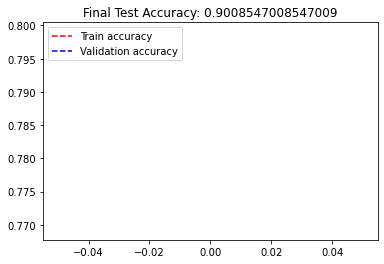

In [186]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

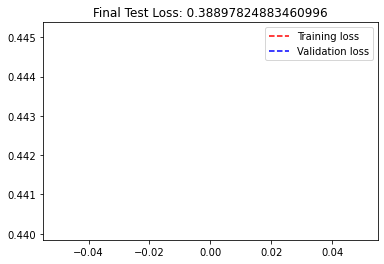

In [187]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './latest_16epochs')

In [130]:
torch.save({'model_state_dict': autoencmodel.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, './autoenc')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest")["model_state_dict"])
test_losses, test_accuracy = test(model_test, test_loader)

## For plotting curves

In [54]:
print(train_losses)

[1.6117338977361981, 0.6752263307571411, 0.5315211164323908, 0.4871035829970711, 0.43616697505900737, 0.40006870815628454, 0.3981376211894186, 0.3626742362976074, 0.34161080498444407, 0.3216301296886645, 0.3418271525910026, 0.34707130962296534, 0.31332921119112717, 0.30196401868995865, 0.2961609889017908, 0.303050907034623, 0.2797347660127439]


In [55]:
print(train_accuracies)

[0.5554844216816048, 0.589628681177977, 0.7052923602219376, 0.7439180537772087, 0.7676056338028169, 0.7831839521980367, 0.8000426803243704, 0.8427230046948356, 0.8461374306444729, 0.845497225778916, 0.8491250533504054, 0.8446436192915067, 0.8738796414852753, 0.882202304737516, 0.8753734528382415, 0.8858301323090055, 0.8915919760990183]


In [56]:
print(val_losses)

[1.674697995185852, 0.5230533480644226, 0.3147006034851074, 0.305906484524409, 0.3257645070552826, 0.3222278356552124, 0.2800224721431732, 0.29525457074244815, 0.28916412095228833, 0.2648814270893733, 0.2847808450460434, 0.3306647265950839, 0.2797544449567795, 0.2561985452969869, 0.40685732662677765, 0.37658636023600894, 0.3388497332731883]


In [57]:
print(val_accuracies)

[0.39829059829059826, 0.694017094017094, 0.8666666666666667, 0.882051282051282, 0.8683760683760684, 0.8735042735042735, 0.8957264957264958, 0.9042735042735043, 0.9094017094017094, 0.9111111111111111, 0.8769230769230769, 0.9111111111111111, 0.9025641025641026, 0.9094017094017094, 0.9025641025641026, 0.9179487179487179, 0.8940170940170941]
